## 1. Imports & basic configuration

In [1]:
# Cell 1: imports & configuration
import numpy as np
import matplotlib.pyplot as plt
import time

# Smaller grid for quick tests; scale up once stable
NX, NY, NZ = 32, 32, 32
NTHETA     = 16

# Domain extents
X_MAX, Y_MAX, Z_MAX = 5.0, 5.0, 5.0

# Time stepping (Strang-splitting)
DT    = 1e-3
T_END = 0.2      # start small for speed; increase later
STEPS = int(T_END / DT)

# Physical params (dimensionless units for simplicity)
M    = 1.0       # mass in XYZ
I    = 1.0       # "moment of inertia" (θ direction)
Q    = 0.5       # coupling to A_theta
hbar = 1.0


## 2. Grids, volume element, and potentials

In [62]:
# Cell 2: grids & potentials
x = np.linspace(-X_MAX, X_MAX, NX); dx = x[1] - x[0]
y = np.linspace(-Y_MAX, Y_MAX, NY); dy = y[1] - y[0]
z = np.linspace(-Z_MAX, Z_MAX, NZ); dz = z[1] - z[0]
theta = np.linspace(-np.pi, np.pi, NTHETA, endpoint=False)
dtheta = theta[1] - theta[0]

XX, YY, ZZ, TTH = np.meshgrid(x, y, z, theta, indexing="ij")
vol = dx * dy * dz * dtheta

# Harmonic trap in XYZ (symmetric)
V = 0.5 * (XX**2 + YY**2 + ZZ**2)

# Position-dependent internal connection A_theta(x)
# (linear in x so the sign flips with x -> -x)
A_theta = 0.2 * XX


In [63]:
# Run this right after Cell 2 (where you created XX, YY, ZZ, TTH)

# A_theta should depend on (x,y,z) only. Drop θ axis:
A_theta_3d = 0.2 * XX[..., 0]     # shape: (NX, NY, NZ)

# (Optional) sanity checks
assert A_theta_3d.shape == (NX, NY, NZ)


## 3. Momentum grids and kinetic phase operators
We keep XYZ kinetic in (kx,ky,kz) space, but we move θ kinetic (with coupling) into m-space and apply it with a θ-FFT each step.

momentum grids (use a 1-D m vector, not a meshgrid)

In [64]:
# Cell 3: momentum grids & kinetic operators (SAFE)
import numpy as np

# XYZ Fourier modes
kx = 2*np.pi*np.fft.fftfreq(NX, d=dx)
ky = 2*np.pi*np.fft.fftfreq(NY, d=dy)
kz = 2*np.pi*np.fft.fftfreq(NZ, d=dz)
KKX, KKY, KKZ = np.meshgrid(kx, ky, kz, indexing="ij")

# Pure XYZ kinetic (no theta here)
Hk_xyz      = (hbar**2 / (2*M)) * (KKX**2 + KKY**2 + KKZ**2)
U_K_xyz     = np.exp(-1j * DT     * Hk_xyz / hbar)
U_K_xyz_half= np.exp(-1j * (DT/2) * Hk_xyz / hbar)

# IMPORTANT: 1-D vector of theta Fourier modes.
# Do NOT create a meshgrid named MM; keep this strictly 1-D.
m_vec = np.fft.fftfreq(NTHETA, d=1.0/NTHETA)  # shape (NTHETA,)

# Optional cleanup in case an old MM is lurking in your workspace:
try:
    del MM
except NameError:
    pass


## 4. Initial wavefunction (allow m-bias to test physics)

In [65]:
# Cell 4: initial psi and helpers
def normalize(psi):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * vol)
    return psi / nrm

# m-bias: set m0 != 0 to break the symmetric m-distribution
#m0 = 0   # try m0=+2 or -2 later to see controlled drift and sign flip
m0 = -2   # try m0=+2 or -2 later to see controlled drift and sign flip

# Spatial Gaussian
psi_xyz = np.exp(-(XX**2 + YY**2 + ZZ**2) / (2*1.0**2))

# Theta Gaussian around 0, optionally with plane-wave factor e^{i m0 theta}
psi_th  = np.exp(-(TTH**2) / (2*0.5**2)) * np.exp(1j * m0 * TTH)

psi = psi_xyz * psi_th
psi = normalize(psi)

# Precompute potential half-step
U_V_half = np.exp(-1j * (DT/2) * V / hbar)


## 5. θ-kinetic with Aθ(x): correct minimal coupling in m-space
U
θ
	​

(x,m)=exp[−
2Iℏ
iΔt
	​

(ℏm−QA
θ
	​

(x))
2
]

We’ll apply this as a 1D FFT in θ, multiply by 
𝑈
𝜃
U
θ
	​

, then inverse FFT back.

In [66]:
# Cell 5: theta kinetic step (with A_theta) as a helper (SAFE)

def theta_kinetic_step(psi, dt):
    """
    Apply exp(-i dt/(2 I ħ) * (ħ m - Q A_theta(x))^2) along θ.
    psi: complex (NX,NY,NZ,NTHETA)
    """
    psi_m = np.fft.fft(psi, axis=3)             # (NX,NY,NZ,NTHETA)

    # Broadcast shapes:
    # a: (NX,NY,NZ,1) ; m: (1,1,1,NTHETA)
    a = (Q * A_theta_3d)[..., None]
    m = m_vec.reshape(1,1,1,-1)

    U_th = np.exp(-1j * dt / (2*I*hbar) * ( (hbar*m - a)**2 ))  # (NX,NY,NZ,NTHETA)
    psi_m *= U_th

    return np.fft.ifft(psi_m, axis=3)



## 6. Observables and evolution kernels
We’ll use a symmetric split: 
𝑉
/
2
→
𝑇
𝑥
𝑦
𝑧
/
2
→
𝑇
𝜃
→
𝑇
𝑥
𝑦
𝑧
/
2
→
𝑉
/
2
V/2→T
xyz
	​

/2→T
θ
	​

→T
xyz
	​

/2→V/2.

In [67]:
# Cell 6: observables & evolution steps
def exp_kin_xyz(psi, U):
    # 3D FFT over xyz, leaving theta axis untouched
    psi_k = np.fft.fftn(psi, axes=(0,1,2))
    psi_k *= U[..., None]  # broadcast over theta
    return np.fft.ifftn(psi_k, axes=(0,1,2))

def expect_x(psi):
    dens = np.abs(psi)**2
    return np.sum(dens * XX) * vol

def total_prob(psi):
    return np.sum(np.abs(psi)**2) * vol

def evolve_one_step(psi):
    # V half
    psi = U_V_half * psi

    # T_xyz half
    psi = exp_kin_xyz(psi, U_K_xyz_half)

    # T_theta full (with A_theta(x))
    psi = theta_kinetic_step(psi, DT)

    # T_xyz half
    psi = exp_kin_xyz(psi, U_K_xyz_half)

    # V half
    psi = U_V_half * psi
    return psi


## 7. Run the simulation, collect ⟨x⟩ and norm

In [68]:
# Cell 7: time loop
xs, norms = [], []
t0 = time.time()

psi_t = psi.copy()
for step in range(STEPS+1):
    if step % max(1, STEPS//10) == 0:
        xs.append(expect_x(psi_t).real)
        norms.append(total_prob(psi_t).real)
        print(f"step {step:5d}/{STEPS}, <x>={xs[-1]: .6e}, norm={norms[-1]:.12f}")

    if step < STEPS:
        psi_t = evolve_one_step(psi_t)

t1 = time.time()
print(f"Finished in {(t1-t0):.2f}s")


step     0/200, <x>=-7.215858e-18, norm=1.000000000000
step    20/200, <x>=-3.999819e-05, norm=1.000000000000
step    40/200, <x>=-1.599766e-04, norm=1.000000000000
step    60/200, <x>=-3.598868e-04, norm=1.000000000000
step    80/200, <x>=-6.396479e-04, norm=1.000000000000
step   100/200, <x>=-9.991470e-04, norm=1.000000000000
step   120/200, <x>=-1.438239e-03, norm=1.000000000000
step   140/200, <x>=-1.956746e-03, norm=1.000000000000
step   160/200, <x>=-2.554459e-03, norm=1.000000000000
step   180/200, <x>=-3.231137e-03, norm=1.000000000000
step   200/200, <x>=-3.986505e-03, norm=1.000000000000
Finished in 45.23s


## 8. Plot diagnostics

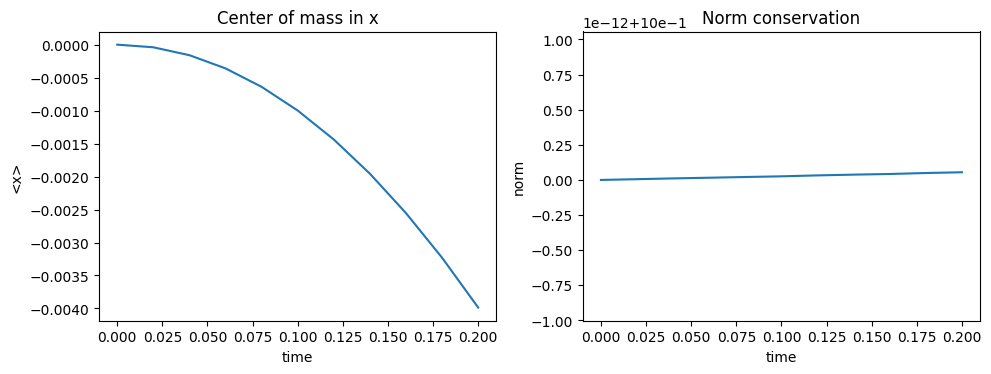

In [69]:
# Cell 8: plots
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(np.linspace(0,T_END,len(xs)), xs)
ax[0].set_xlabel("time")
ax[0].set_ylabel("<x>")
ax[0].set_title("Center of mass in x")

ax[1].plot(np.linspace(0,T_END,len(norms)), norms)
ax[1].set_xlabel("time")
ax[1].set_ylabel("norm")
ax[1].set_title("Norm conservation")

plt.tight_layout()
plt.show()


In [ ]:
# Save diagnostic plot to Paper/figs using style.savefig
import sys
sys.path.append('../src/plot')
import style
style.savefig('../../paper/figs/3d_double_slit_diagnostics.png')